In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
matches=pd.read_csv("matches.csv")
deliveries=pd.read_csv("deliveries.csv")

In [3]:
matches.sample(5)


,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
500,829791,2015,Kolkata,2015-05-09,League,AD Russell,Eden Gardens,Kolkata Knight Riders,Kings XI Punjab,Kings XI Punjab,bat,Kolkata Knight Riders,wickets,1.0,184.0,20.0,N,NaN,AK Chaudhary,HDPK Dharmasena
549,980965,2016,Delhi,2016-05-05,League,AM Rahane,Feroz Shah Kotla,Delhi Daredevils,Rising Pune Supergiants,Rising Pune Supergiants,field,Rising Pune Supergiants,wickets,7.0,163.0,20.0,N,NaN,C Shamshuddin,RJ Tucker
737,1178417,2019,Bengaluru,2019-04-24,League,AB de Villiers,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Kings XI Punjab,Kings XI Punjab,field,Royal Challengers Bangalore,runs,17.0,203.0,20.0,N,NaN,BNJ Oxenford,C Shamshuddin
298,548359,2012,Hyderabad,2012-05-08,League,Mandeep Singh,"Rajiv Gandhi International Stadium, Uppal",Deccan Chargers,Kings XI Punjab,Deccan Chargers,field,Kings XI Punjab,runs,25.0,171.0,20.0,N,NaN,HDPK Dharmasena,BNJ Oxenford
394,598070,2013,Delhi,2013-05-21,Qualifier 1,MEK Hussey,Feroz Shah Kotla,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,bat,Chennai Super Kings,runs,48.0,193.0,20.0,N,NaN,NJ Llong,RJ Tucker


In [4]:
deliveries.sample(5)

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
230154,1359492,1,Punjab Kings,Gujarat Titans,11,1,JM Sharma,Mohammed Shami,PBB Rajapaksa,4,0,4,NaN,0,NaN,NaN,NaN
136431,981019,1,Sunrisers Hyderabad,Royal Challengers Bangalore,13,4,DJ Hooda,S Aravind,Yuvraj Singh,1,0,1,NaN,0,NaN,NaN,NaN
225064,1312197,1,Rajasthan Royals,Gujarat Titans,13,7,D Padikkal,R Sai Kishore,JC Buttler,1,0,1,NaN,0,NaN,NaN,NaN
71323,548361,1,Rajasthan Royals,Chennai Super Kings,5,4,SR Watson,BW Hilfenhaus,AM Rahane,0,0,0,NaN,1,SR Watson,caught,R Ashwin
145106,1082627,2,Kolkata Knight Riders,Sunrisers Hyderabad,19,6,C de Grandhomme,S Kaul,CR Woakes,0,0,0,NaN,1,C de Grandhomme,caught,Rashid Khan


HANDLING NULL VALUES# 

In [5]:
matches.isnull().sum()

id                    0
season                0
city                 51
date                  0
match_type            0
player_of_match       5
venue                 0
team1                 0
team2                 0
toss_winner           0
toss_decision         0
winner                5
result                0
result_margin        19
target_runs           3
target_overs          3
super_over            0
method             1074
umpire1               0
umpire2               0
dtype: int64

In [6]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1095 non-null   int64  
 1   season           1095 non-null   object 
 2   city             1044 non-null   object 
 3   date             1095 non-null   object 
 4   match_type       1095 non-null   object 
 5   player_of_match  1090 non-null   object 
 6   venue            1095 non-null   object 
 7   team1            1095 non-null   object 
 8   team2            1095 non-null   object 
 9   toss_winner      1095 non-null   object 
 10  toss_decision    1095 non-null   object 
 11  winner           1090 non-null   object 
 12  result           1095 non-null   object 
 13  result_margin    1076 non-null   float64
 14  target_runs      1092 non-null   float64
 15  target_overs     1092 non-null   float64
 16  super_over       1095 non-null   object 
 17  method        

In [7]:
matches.drop('method',axis=1,inplace=True)
     

In [8]:
matches['city'] = matches['city'].fillna(matches['venue'])
matches['player_of_match'] = matches['player_of_match'].fillna('unknown')
matches['winner'] = matches['winner'].fillna('unknown')
matches['target_runs'] = matches['target_runs'].fillna(0)
matches['target_overs'] = matches['target_overs'].fillna(0)
matches['result_margin'] = matches['result_margin'].fillna(0)

In [9]:
matches.isnull().sum()

id                 0
season             0
city               0
date               0
match_type         0
player_of_match    0
venue              0
team1              0
team2              0
toss_winner        0
toss_decision      0
winner             0
result             0
result_margin      0
target_runs        0
target_overs       0
super_over         0
umpire1            0
umpire2            0
dtype: int64

HANDLING DUPLICATES

In [10]:
print(matches.venue.nunique())
print(matches.team1.nunique())
print(matches.city.nunique())

58
19
38


In [11]:
team_dup={"Delhi Daredevils":"Delhi Capitals",
"Rising Pune Supergiants":"Rising Pune Supergiant",
"Royal Challengers Bengaluru":"Royal Challengers Bangalore",'Gujarat Lions':'Gujarat Titans'}
matches.replace(to_replace=team_dup,inplace=True)

In [12]:
city_dup={'Bengaluru':'Bangalore','Navi Mumbai':'Mumbai','Dubai International Cricket Stadium':'Dubai','Sharjah Cricket Stadium':'Sharjah'}
matches['city'].replace(to_replace=city_dup,inplace=True)

In [13]:
matches.replace('Arun Jaitley Stadium, Delhi','Arun Jaitley Stadium',inplace=True)
matches.replace('Brabourne Stadium, Mumbai','Brabourne Stadium',inplace=True)
matches.replace('Dr DY Patil Sports Academy, Mumbai','Dr DY Patil Sports Academy',inplace=True)
matches.replace('Eden Gardens, Kolkata','Eden Gardens',inplace=True)
matches.replace('Wankhede Stadium, Mumbai','Wankhede Stadium',inplace=True)
matches.replace('Sawai Mansingh Stadium, Jaipur','Sawai Mansingh Stadium',inplace=True)
matches.replace('Zayed Cricket Stadium, Abu Dhabi','Sheikh Zayed Stadium',inplace=True)
matches.replace('MA Chidambaram Stadium, Chepauk','MA Chidambaram Stadium',inplace=True)
matches.replace('MA Chidambaram Stadium, Chepauk, Chennai, Chepauk','MA Chidambaram Stadium',inplace=True)
matches.replace('Maharashtra Cricket Association Stadium, Pune','Maharashtra Cricket Association Stadium',inplace=True)
matches.replace('Subrata Roy Sahara Stadium','Maharashtra Cricket Association Stadium',inplace=True)
matches.replace('M.Chinnaswamy Stadium','M Chinnaswamy Stadium',inplace=True)
matches.replace('Punjab Cricket Association Stadium, Mohali','Punjab Cricket Association Stadium',inplace=True)
matches.replace('Punjab Cricket Association IS Bindra Stadium, Mohali','Punjab Cricket Association Stadium',inplace=True)
matches.replace('Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh','Punjab Cricket Association Stadium',inplace=True)
matches.replace('M Chinnaswamy Stadium, Bengaluru','M Chinnaswamy Stadium',inplace=True)
matches.replace('Rajiv Gandhi International Stadium, Uppal','Rajiv Gandhi International Stadium',inplace=True)
matches.replace('Rajiv Gandhi International Stadium, Uppal, Hyderabad','Rajiv Gandhi International Stadium',inplace=True)
matches.replace('Himachal Pradesh Cricket Association Stadium, Dharamsala','Himachal Pradesh Cricket Association Stadium',inplace=True)
matches.replace('Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam','Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',inplace=True)
     

In [14]:
print(matches.venue.nunique())
print(matches.team1.nunique())
print(matches.city.nunique())
     

40
15
34


HANDLING DUPLICATES IN DELIVERIES

In [15]:
team_dup={"Delhi Daredevils":"Delhi Capitals",
"Rising Pune Supergiants":"Rising Pune Supergiant",
"Royal Challengers Bengaluru":"Royal Challengers Bangalore",'Gujarat Lions':'Gujarat Titans'}
deliveries.replace(to_replace=team_dup,inplace=True)

#INSIGHTS

BEST BATTER AND BOWLER OF THE YEAR

In [17]:
merged_data = deliveries.merge(matches, left_on='match_id', right_on='id')
def best_batter_bowler(year):
  part_year_data=merged_data[merged_data['season']==year]
  batter_data=part_year_data.groupby('batter')['batsman_runs'].sum().reset_index()
  top_batter=batter_data.sort_values(by='batsman_runs',ascending=False)
  print("Top Batter")
  print(top_batter.head(1))
  bowler_data = part_year_data[['match_id', 'bowler', 'is_wicket', 'total_runs']]
  performance = bowler_data.groupby(['match_id', 'bowler']).agg(
    wickets=('is_wicket', 'sum'),
    runs_conceded=('total_runs', 'sum')
  ).reset_index()
  bowlers=performance.groupby('bowler')['wickets'].sum().reset_index()
  top_bowler=bowlers.sort_values(by="wickets",ascending=False)
  print("Top Bowler:")
  print(top_bowler.head(1))

In [18]:
best_batter_bowler('2012')

Top Batter
      batter  batsman_runs
36  CH Gayle           733
Top Bowler:
      bowler  wickets
70  M Morkel       30


# DELIVERABLES OF IPL INFOGRAPHICS

TOP 10 BATSMAN

In [19]:
batsman=deliveries.groupby('batter')['batsman_runs'].sum().reset_index()
sorted_batsman=batsman.sort_values(by='batsman_runs',ascending=False)
top_10_batsman=sorted_batsman.head(10)
top_10_batsman
     

,batter,batsman_runs
631,V Kohli,8014
512,S Dhawan,6769
477,RG Sharma,6630
147,DA Warner,6567
546,SK Raina,5536
374,MS Dhoni,5243
30,AB de Villiers,5181
124,CH Gayle,4997
501,RV Uthappa,4954
282,KD Karthik,4843


Text(0, 0.5, 'scores')

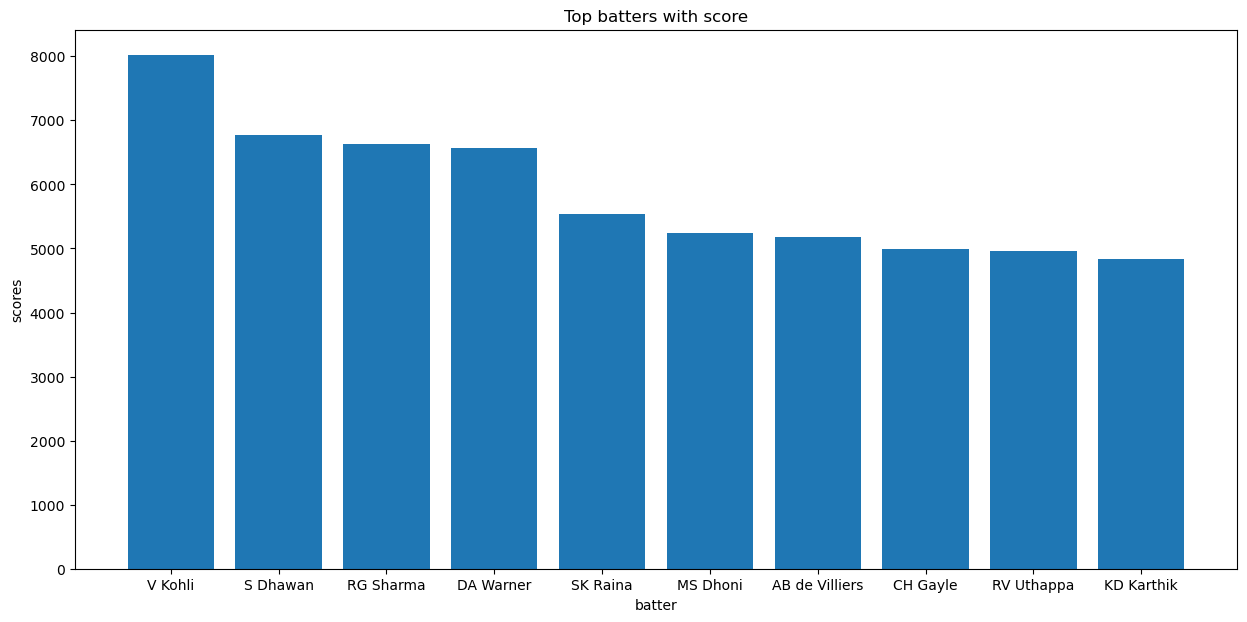

In [20]:
player=top_10_batsman['batter']
scores=top_10_batsman['batsman_runs']
fig = plt.figure(figsize = (15,7))
plt.bar(player,scores)
plt.title('Top batters with score')
plt.xlabel('batter')
plt.ylabel('scores')

# TOP 10 BOWLERS

In [21]:
bowler_data = deliveries[['match_id', 'bowler', 'is_wicket', 'total_runs']]
performance = bowler_data.groupby(['match_id', 'bowler']).agg(
    wickets=('is_wicket', 'sum'),
    runs_conceded=('total_runs', 'sum')
).reset_index()


In [22]:
bowlers=performance.groupby('bowler')['wickets'].sum().reset_index()
top_bowl=bowlers.sort_values(by="wickets",ascending=False)
top_bowlers=top_bowl.head(10)
top_bowlers

,bowler,wickets
524,YS Chahal,213
119,DJ Bravo,207
348,PP Chawla,201
446,SP Narine,200
355,R Ashwin,198
71,B Kumar,195
438,SL Malinga,188
8,A Mishra,183
193,JJ Bumrah,182
373,RA Jadeja,169


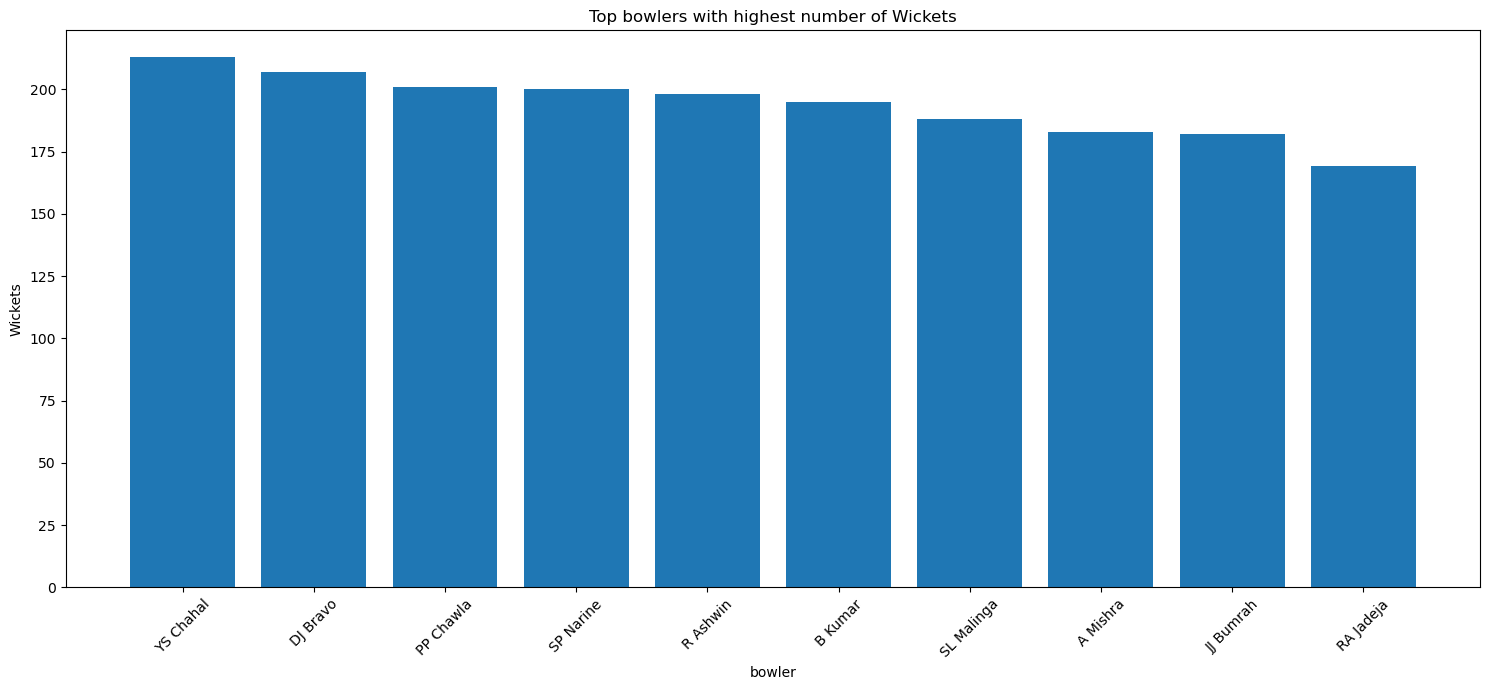

In [23]:
top_10_bowlers=top_bowlers['bowler']
wickets_scored=top_bowlers['wickets']
fig = plt.figure(figsize = (15,7))
plt.bar(top_10_bowlers,wickets_scored)
plt.title('Top bowlers with highest number of Wickets')
plt.xlabel('bowler')
plt.ylabel('Wickets')
plt.xticks(rotation=45)
plt.tight_layout()

# PLAYER LEVEL ANALYSIS

TOP 10 BATSMAN STRIKE RATE ANALYSIS

In [24]:
batsman_data = deliveries[['batter', 'batsman_runs']]
runs = batsman_data.groupby('batter')['batsman_runs'].sum().reset_index()
runs.rename(columns={'batsman_runs': 'total_runs'}, inplace=True)
balls_faced = deliveries[deliveries['extras_type'] != 'wides'].groupby('batter').size().reset_index(name='balls_faced')
batsman_stats = pd.merge(runs, balls_faced, on='batter')
batsman_stats['strike_rate'] = (batsman_stats['total_runs'] / batsman_stats['balls_faced']) * 100
top_10_batsmen = batsman_stats.sort_values(by='strike_rate', ascending=False).head(10)
print(top_10_batsmen)

              batter  total_runs  balls_faced  strike_rate
312           L Wood           9            3   300.000000
97        B Stanlake           5            2   250.000000
234  J Fraser-McGurk         330          141   234.042553
461    R Sai Kishore          13            6   216.666667
629         Umar Gul          39           19   205.263158
497         RS Sodhi           4            2   200.000000
465       R Shepherd         115           63   182.539683
410       Naman Dhir         140           79   177.215190
318        LJ Wright         106           60   176.666667
583    Shahid Afridi          81           46   176.086957


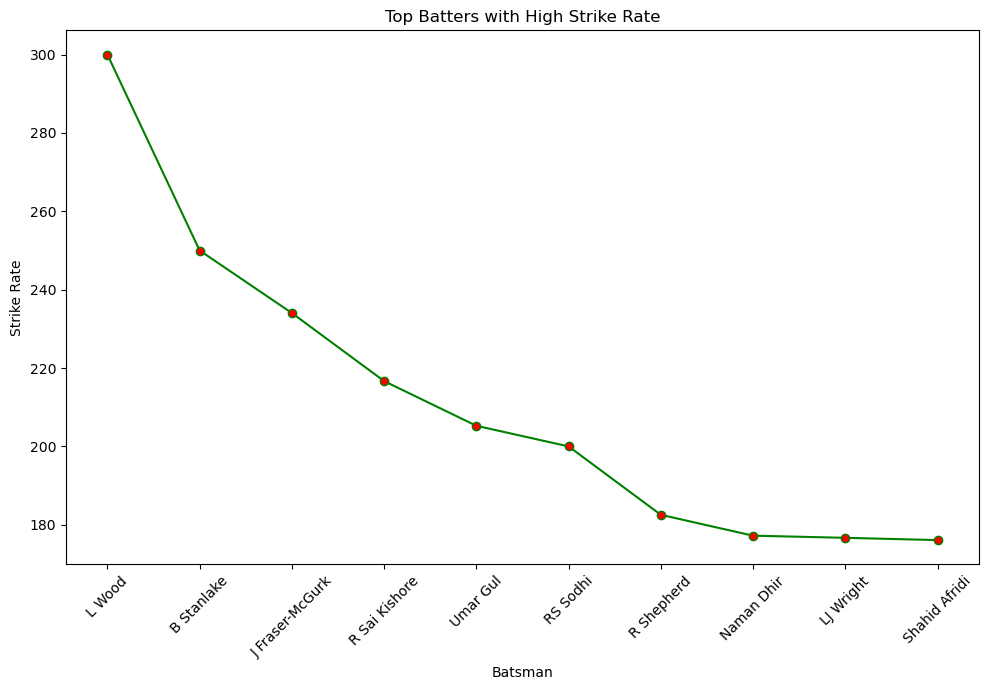

In [25]:
top_batter_strike=top_10_batsmen['batter']
strike_rate=top_10_batsmen['strike_rate']
fig=plt.figure(figsize=(10,7))
plt.plot(top_batter_strike, strike_rate,marker='o',mfc = 'r', color='green', linestyle='-')
plt.title("Top Batters with High Strike Rate")
plt.xlabel("Batsman")
plt.ylabel("Strike Rate")
plt.xticks(rotation=45)
plt.tight_layout()

TOP 15 PLAYER WHO WON MAN OF MATCH

In [26]:
man_of_match=matches.player_of_match.value_counts().reset_index()
top_15=man_of_match.head(15)
top_15
     

,index,player_of_match
0,AB de Villiers,25
1,CH Gayle,22
2,RG Sharma,19
3,DA Warner,18
4,V Kohli,18
5,MS Dhoni,17
6,SR Watson,16
7,YK Pathan,16
8,RA Jadeja,16
9,AD Russell,15


In [35]:
plt.figure(figsize=(12, 7))
bars = plt.bar(top_15["player_of_match"], top_15["count"], color='olive', label='Man of the Match count')
plt.plot(top_15["player_of_match"], top_15["count"], color='blue', linestyle='-', linewidth=2, label='Trend Line')
plt.title("Top 15 Players Who Won the Most Man of the Match Awards")
plt.xlabel("Players")
plt.ylabel("Man of the Match Award count")
plt.xticks(rotation=45)
plt.tight_layout()

KeyError: 'count'

<Figure size 1200x700 with 0 Axes>

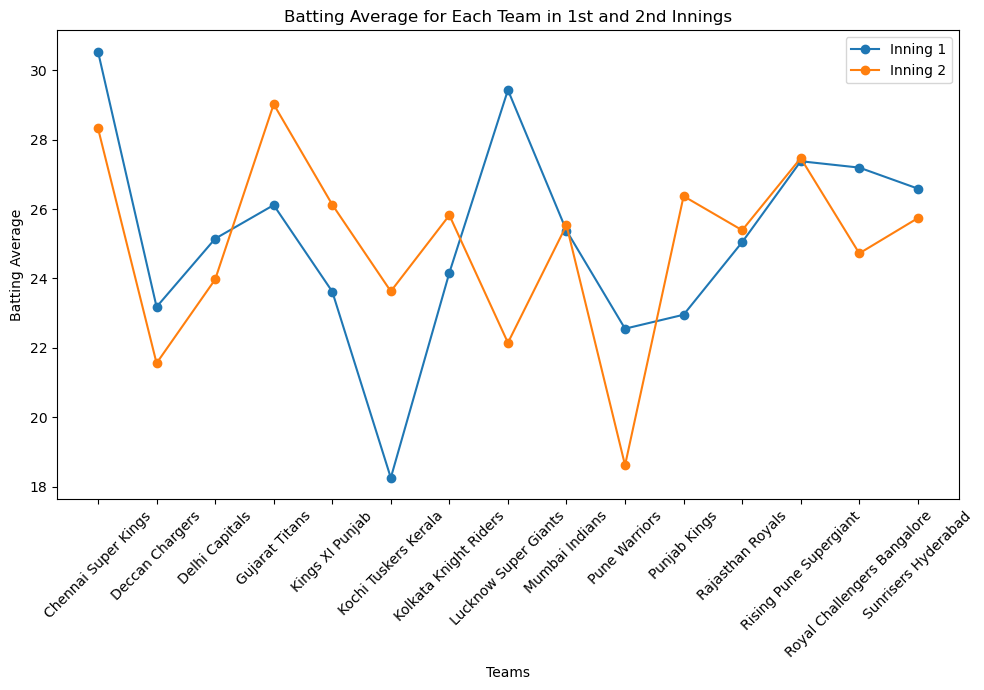

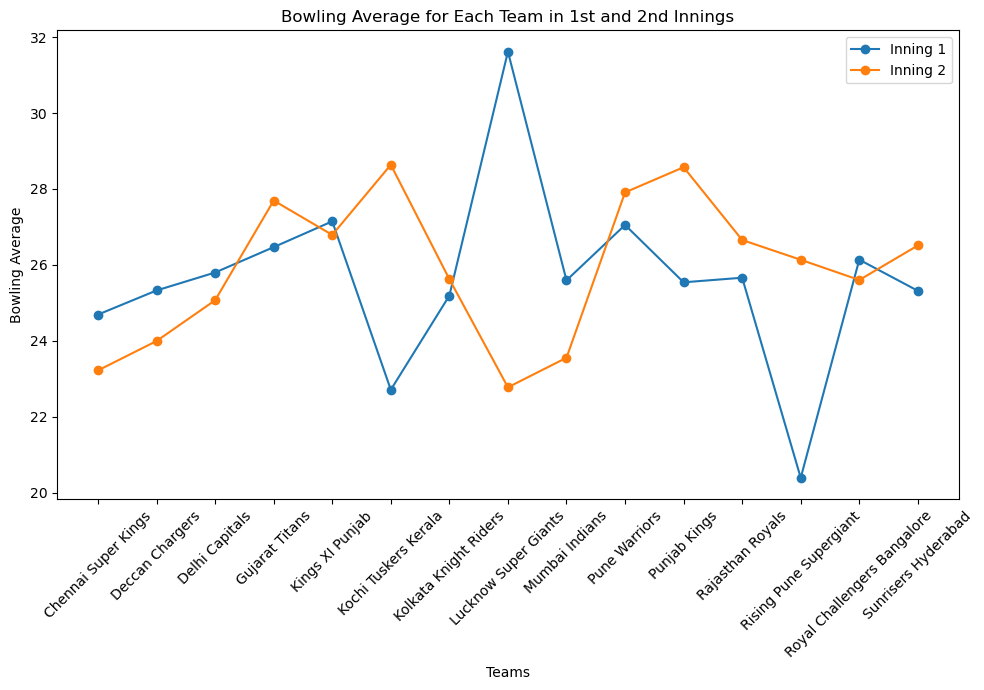

In [36]:

merged_data = deliveries.merge(matches, left_on='match_id', right_on='id')

# Step 1: Calculate Batting Average
batting_data = merged_data[['inning', 'batting_team', 'batsman_runs', 'is_wicket']]
batting_summary = batting_data.groupby(['inning', 'batting_team']).agg(
    Total_Runs=('batsman_runs', 'sum'),
    Total_Outs=('is_wicket', 'sum')
).reset_index()
batting_summary['Batting_Average'] = batting_summary['Total_Runs'] / batting_summary['Total_Outs']

# Step 2: Calculate Bowling Average
bowling_data = merged_data[['inning', 'bowling_team', 'batsman_runs', 'is_wicket']]
bowling_summary = bowling_data.groupby(['inning', 'bowling_team']).agg(
    Total_Runs_Conceded=('batsman_runs', 'sum'),
    Total_Wickets=('is_wicket', 'sum')
).reset_index()
bowling_summary['Bowling_Average'] = bowling_summary['Total_Runs_Conceded'] / bowling_summary['Total_Wickets']

# Step 3: Plot Batting Average
plt.figure(figsize=(10,7))
for inning in [1, 2]:
    data = batting_summary[batting_summary['inning'] == inning]
    plt.plot(data['batting_team'], data['Batting_Average'], marker='o', linestyle='-', label=f"Inning {inning}")

plt.title("Batting Average for Each Team in 1st and 2nd Innings")
plt.xlabel("Teams")
plt.ylabel("Batting Average")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Step 4: Plot Bowling Average
plt.figure(figsize=(10,7))
for inning in [1, 2]:
    data = bowling_summary[bowling_summary['inning'] == inning]
    plt.plot(data['bowling_team'], data['Bowling_Average'], marker='o', linestyle='-', label=f"Inning {inning}")

plt.title("Bowling Average for Each Team in 1st and 2nd Innings")
plt.xlabel("Teams")
plt.ylabel("Bowling Average")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# TOP 10 BOWLERS ECONOMY RATE ANALYSIS

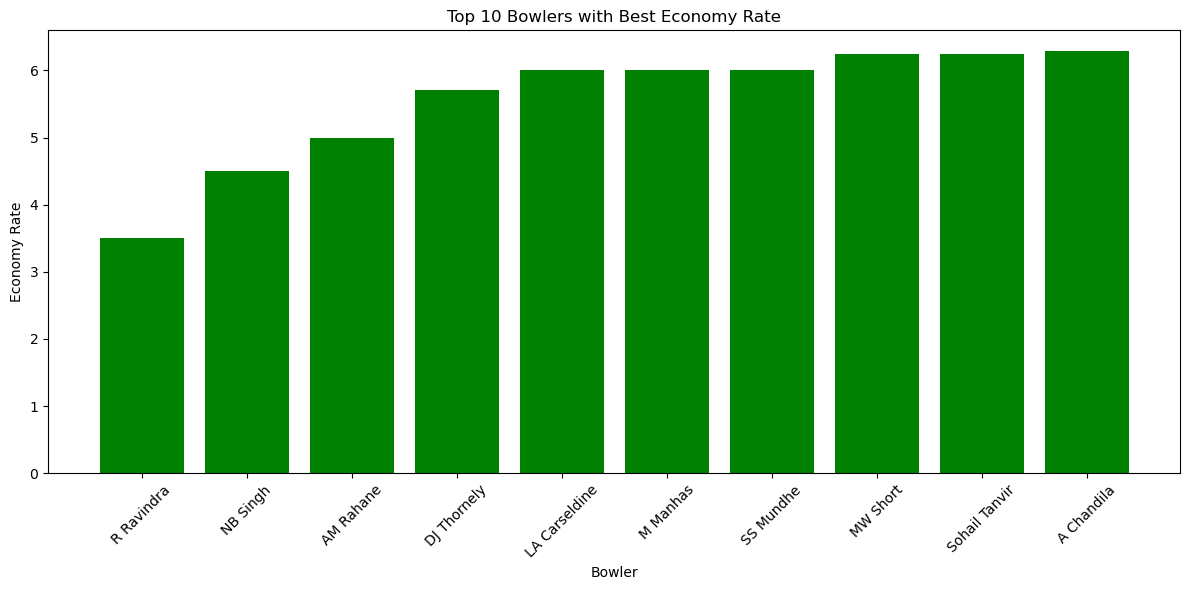

In [37]:
# Step 1: Calculate Total Runs Conceded and Balls Bowled for Each Bowler
bowler_stats = deliveries.groupby('bowler').agg(
    total_runs_conceded=('total_runs', 'sum'),
    total_balls=('ball', 'count')
).reset_index()

# Step 2: Calculate Overs Bowled
bowler_stats['overs'] = bowler_stats['total_balls'] // 6

# Step 3: Filter out bowlers with zero overs to avoid division errors
bowler_stats = bowler_stats[bowler_stats['overs'] > 0]

# Step 4: Calculate Economy Rate
bowler_stats['economy_rate'] = bowler_stats['total_runs_conceded'] / bowler_stats['overs']

# Step 5: Sort and Get Top 10 Bowlers with Lowest Economy Rate
top_10_economy_bowlers = bowler_stats.sort_values(by='economy_rate').head(10)
plt.figure(figsize=(12, 6))
plt.bar(top_10_economy_bowlers['bowler'], top_10_economy_bowlers['economy_rate'], color='green')
plt.title('Top 10 Bowlers with Best Economy Rate')
plt.xlabel('Bowler')
plt.ylabel('Economy Rate')
plt.xticks(rotation=45)
plt.tight_layout()

In [39]:
# Batting Performance
batting = deliveries.groupby('batter').agg(
    Total_Runs=('batsman_runs', 'sum'),
    Balls_Faced=('ball', 'count'),
    Dismissals=('is_wicket', 'sum')
).reset_index()
batting['Strike_Rate'] = (batting['Total_Runs'] / batting['Balls_Faced']) * 100
batting['Batting_Average'] = batting.apply(
    lambda x: x['Total_Runs'] if x['Dismissals'] == 0 else x['Total_Runs'] / x['Dismissals'], axis=1
)

# Bowling Performance
bowling = deliveries.groupby('bowler').agg(
    Total_Wickets=('is_wicket', 'sum'),
    Total_Runs_Conceded=('batsman_runs', 'sum'),
    Total_Balls=('ball', 'count')
).reset_index()
bowling['Overs'] = bowling['Total_Balls'] // 6
bowling['Economy_Rate'] = bowling['Total_Runs_Conceded'] / bowling['Overs']
bowling['Bowling_Average'] = bowling['Total_Runs_Conceded'] / bowling['Total_Wickets']

# Fielding Performance
fielding = deliveries.groupby('fielder').agg(
    Total_Catches=('is_wicket', 'sum')
).reset_index()

all_rounders = pd.merge(batting, bowling, left_on='batter', right_on='bowler', how='inner')
all_rounders = pd.merge(all_rounders, fielding, left_on='batter', right_on='fielder', how='left')
# Fill missing fielding stats with 0
all_rounders['Total_Catches'] = all_rounders['Total_Catches'].fillna(0)

# Normalize Metrics

# Normalize Batting Scores
max_batting_average = all_rounders['Batting_Average'].max()

if max_batting_average > 0:
    all_rounders['Batting_Score'] = all_rounders['Batting_Average'] / max_batting_average
else:
    all_rounders['Batting_Score'] = 0  # If no player has a valid batting average
all_rounders['Bowling_Score'] = all_rounders['Total_Wickets'] / all_rounders['Total_Wickets'].max()
all_rounders['Fielding_Score'] = all_rounders['Total_Catches'] / all_rounders['Total_Catches'].max()
# Weighted All-Rounder Score
all_rounders['All_Rounder_Score'] = (
    0.4 * all_rounders['Batting_Score'] +
    0.4 * all_rounders['Bowling_Score'] +
    0.2 * all_rounders['Fielding_Score']
)
top_all_rounders = all_rounders.sort_values('All_Rounder_Score', ascending=False).head(10)
print(top_all_rounders[['batter', 'All_Rounder_Score']])



            batter  All_Rounder_Score
108       DJ Bravo           0.615163
332      RA Jadeja           0.612453
159  Iqbal Abdulla           0.507408
315       R Ashwin           0.500640
396      SP Narine           0.498290
308      PP Chawla           0.494401
466      YS Chahal           0.472305
65         B Kumar           0.455961
39        AR Patel           0.452262
8         A Mishra           0.442275


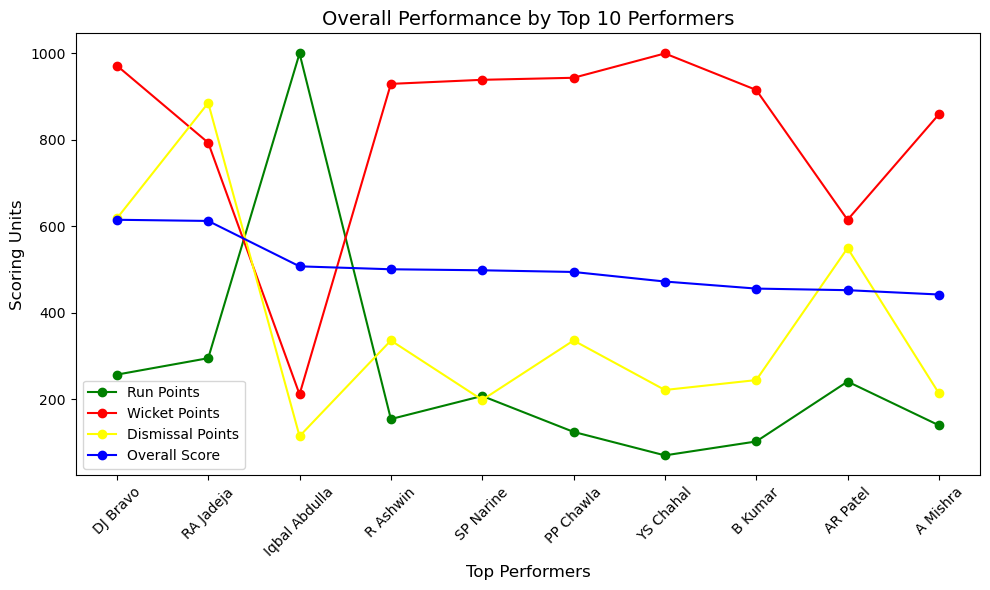

In [40]:
players = top_all_rounders['batter']
run_points = top_all_rounders['Batting_Score'] * 1000  # Scaled for visualization
wicket_points = top_all_rounders['Bowling_Score'] * 1000
dismissal_points = top_all_rounders['Fielding_Score'] * 1000
overall_score = top_all_rounders['All_Rounder_Score'] * 1000
plt.figure(figsize=(10, 6))
plt.plot(players, run_points, label="Run Points", color='green', marker='o')
plt.plot(players, wicket_points, label="Wicket Points", color='red', marker='o')
plt.plot(players, dismissal_points, label="Dismissal Points", color='yellow', marker='o')
plt.plot(players, overall_score, label="Overall Score", color='blue', marker='o')
plt.title("Overall Performance by Top 10 Performers", fontsize=14)
plt.xlabel("Top Performers", fontsize=12)
plt.ylabel("Scoring Units", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()